In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from rlxutils import subplots
from itertools import product

sys.path.append("..")
from lib import io
from lib import sar
import torch

np.set_printoptions(edgeitems=4, linewidth=180)

from importlib import reload
reload(sar)

<module 'lib.sar' from '/home/alberto/github/sar-recovery/notebooks/../lib/sar.py'>

In [2]:
base_path = "/home/alberto/data/data/RST2/Barcelona"
date = '20100520'


## load scatter matrix from files


In [3]:
sm = io.load_bcn_scatter_matrix(base_path, date)
sm.shape

(4402, 1602, 2, 2)

## get scattering vector $\mathbf{w}_l$


In [4]:
wl = sar.get_scattering_vector_from_S_matrix(sm)
wl.shape

(4402, 1602, 3)

## compute coherence matrix pixel wise with no averaging


In [5]:
cm = sar.compute_coherence_matrix(sm)
cm.shape

(4402, 1602, 3, 3)

In [6]:
cm2 = sar.get_covariance_matrix_from_w(wl)
cm2.shape

(4402, 1602, 3, 3)

In [7]:
# This equality does not hold due to the computation of cross-pol channel as (HV+VH)/sqrt(2)
np.allclose(cm, cm2)

False

In [8]:
(np.abs(cm - cm2) / np.abs(cm2)).mean(axis=(0,1)) < 1e-6

array([[ True, False,  True],
       [False, False, False],
       [ True, False,  True]])

## compute normalized coherence matrix from scatter matrix and window size 7

In [9]:
ncm1 = sar.compute_quadpol_normalized_coherence_matrix(sm, window_size=7)

## normalize pixel wise coherence matrix with window size 7

In [10]:
ncm2 = sar.normalize_quadpol_coherence_matrix(cm, window_size=7)

In [11]:
np.allclose(ncm1,  ncm2, atol=1e-5)

True

## Check de-normalization to recover original covariance matrices

In [12]:
Cin = sar.avgpool2D_complex(cm, window_size=7)
P = np.einsum("...ii->...", Cin)
print(P.shape)
Cest = sar.denormalize_quadpol_coherence_matrix(ncm1, P)
print(Cest.shape)
np.linalg.norm(Cin - Cest, axis=(0,1))

(628, 228)
(628, 228, 3, 3)


array([[ 2.7430933,  6.07755  ,  8.863633 ],
       [ 5.811034 ,  1.6077621,  8.054128 ],
       [42.087227 ,  6.8239307,  8.282058 ]], dtype=float32)

In [13]:
# Check average pooling first pixel
np.allclose(cm[0:7,0:7,...].mean(axis=(0,1)), Cin[0,0])


True

In [14]:
# Ensure matrix reconstruction relative error is close to 0
np.allclose(np.linalg.norm(Cin-Cest, axis=(-2,-1)) / np.linalg.norm(Cin, axis=(-2,-1)), 0, atol=1e-6)

True

In [15]:
# Ensure that sum of all d_i is equal to 1
np.allclose(ncm1[...,0:3].sum(axis=-1), 1)

True

In [16]:
# Ensure all rhos absolute value <=1
np.alltrue( np.sum(np.abs(ncm1[..., 3:].reshape(-1,3,2))**2, axis=-1) <= 1 )

True

In [17]:
W = np.linalg.eigvals(Cest)
# Ensure all eigenvalues are real
print(np.allclose(W.imag, 0))
# Ensure all eigenvalues are positive
print(np.alltrue(W.real >= 0))

True
True


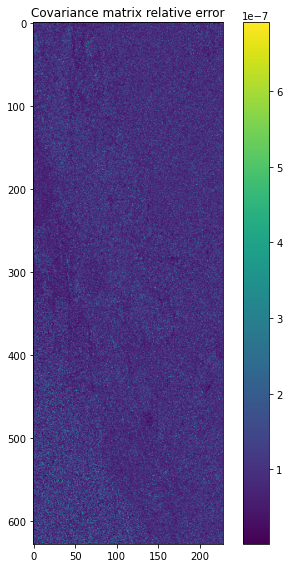

In [18]:
plt.figure(figsize=(6,8))
plt.imshow(np.linalg.norm(Cin-Cest, axis=(-2,-1)) / np.linalg.norm(Cin, axis=(-2,-1)))
plt.title("Covariance matrix relative error")
plt.colorbar()
plt.tight_layout()

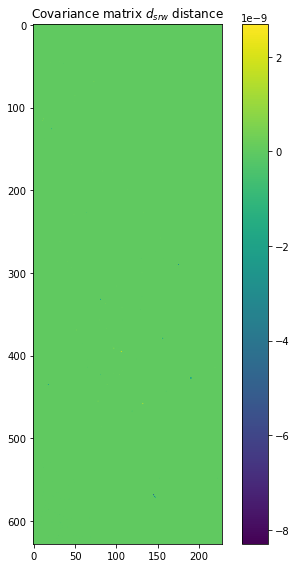

In [19]:
plt.figure(figsize=(6,8))
plt.imshow(sar.symmetric_revised_Wishart_distance(Cin, Cest))
plt.title(r"Covariance matrix $d_{srw}$ distance")
plt.colorbar()
plt.tight_layout()